In [1]:
import time
import torch
import torchvision

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

from torchsummary import summary
from IPython.display import clear_output
from torch.utils.data import DataLoader

In [2]:
SEED = 0xDEAD
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.random.manual_seed(SEED)
torch.cuda.random.manual_seed_all(SEED)

### Data

In [3]:
batch_size = 128

transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

trainset = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=train_transform
)
testset = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=True, transform=transform
)

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
def check_dataset_consistency(loader, dataset_name):
    first_image_shape = None
    consistent = True

    for images, _ in loader:
        first_image = images[0]

        if first_image_shape is None:
            first_image_shape = first_image.shape
        elif first_image.shape != first_image_shape:
            print(f"{dataset_name} images have inconsistent sizes {first_image_shape} vs {first_image.shape}")
            consistent = False
            break

    if consistent:
        print(f"{dataset_name} images are consistent {first_image_shape}")

check_dataset_consistency(trainloader, "Train")
check_dataset_consistency(testloader, "Test")

Train images are consistent torch.Size([3, 32, 32])
Test images are consistent torch.Size([3, 32, 32])


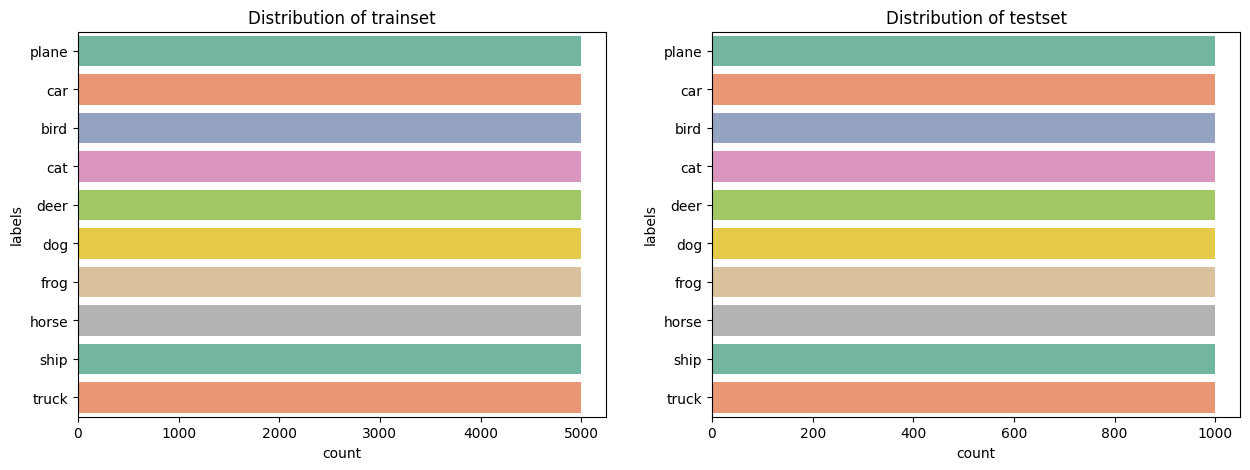

In [5]:
class_counts_train = [len(np.argwhere(np.array(trainset.targets) == i)) for i in range(10)]
class_counts_test = [len(np.argwhere(np.array(testset.targets) == i)) for i in range(10)]

df_train = pd.DataFrame({'labels': classes, 'count': class_counts_train})
df_test = pd.DataFrame({'labels': classes, 'count': class_counts_test})

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(data=df_train, x='count', y='labels', ax=axs[0], palette='Set2', hue='labels')
axs[0].set_title('Distribution of trainset')

sns.barplot(data=df_test, x='count', y='labels', ax=axs[1], palette='Set2', hue='labels')
axs[1].set_title('Distribution of testset')

plt.show()

Files already downloaded and verified


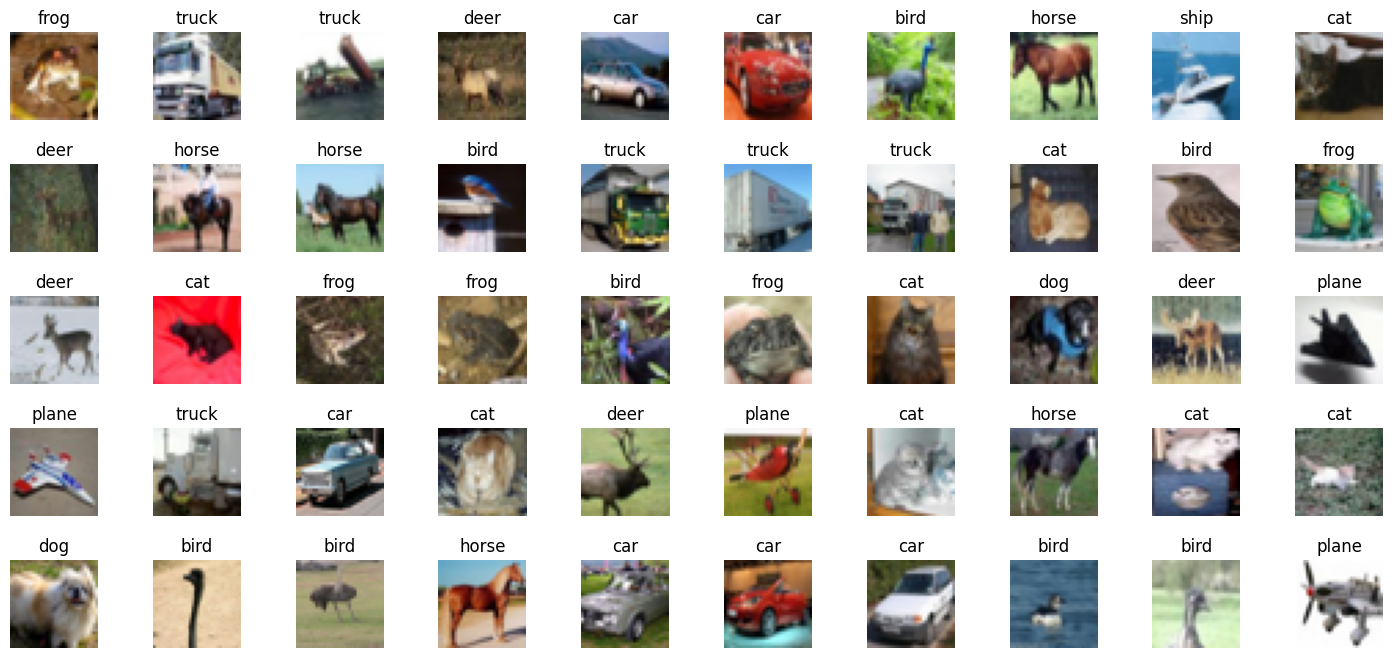

In [6]:
def imshow_grid(trainset, rows, cols):
    _, axes = plt.subplots(rows, cols, figsize=(18, 8))

    for i in range(rows):
        for j in range(cols):
            img, label = trainset[i * cols + j]
            img = np.array(img)
            img = np.transpose(img, (0, 1, 2))
            img = img.astype("uint8")

            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            axes[i, j].set_title(classes[label])

    plt.subplots_adjust(wspace=0.3, hspace=0.5)
    plt.show()

trainset_without_transform = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=True, transform=None
)

imshow_grid(trainset_without_transform, rows=5, cols=10)

nice

### Utils

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [8]:
def plot_training_progress(
    train_loss_history, test_loss_history, train_accuracy_history, test_accuracy_history
):
    clear_output(wait=True)

    epoch = len(train_loss_history) - 1

    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss_history, "-x", label="train")
    plt.plot(test_loss_history, "-x", label="test")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.legend()
    plt.title("Loss")
    plt.grid(linewidth=0.1)

    current_train_loss = train_loss_history[-1]
    current_test_loss = test_loss_history[-1]

    plt.text(epoch, current_train_loss, f"{current_train_loss:.3f}", va="center", ha="right")
    plt.text(len(test_loss_history) - 1, current_test_loss, f"{current_test_loss:.3f}", va="center", ha="right",)

    plt.subplot(1, 2, 2)
    plt.plot(train_accuracy_history, "-x", label="train")
    plt.plot(test_accuracy_history, "-x", label="test")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.grid(linewidth=0.1)

    current_train_accuracy = train_accuracy_history[-1]
    current_test_accuracy = test_accuracy_history[-1]

    plt.text(epoch, current_train_accuracy, f"{current_train_accuracy:.2f}%", va="center", ha="right",)
    plt.text(epoch, current_test_accuracy, f"{current_test_accuracy:.2f}%", va="center", ha="right",)

    plt.tight_layout()
    plt.show()

In [9]:
def train_one_epoch(model, trainloader, criterion, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct = 0
    total_samples = 0

    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
            
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_samples += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    if scheduler: 
        scheduler.step()

    return total_loss / len(trainloader), 100 * correct / total_samples

In [10]:
def evaluate(model, testloader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total_samples = 0

    with torch.no_grad():
        for inputs, labels in testloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            total_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct += (predicted == labels).sum().item()

    return total_loss / len(testloader), (correct / total_samples) * 100

In [11]:
def train_and_evaluate(
    model, trainloader, testloader, criterion, optimizer, scheduler, num_epochs
):
    train_loss_history = []
    test_loss_history = []
    train_accuracy_history = []
    test_accuracy_history = []
    epoch_times = []

    for epoch in range(num_epochs):
        start_time = time.time()
        train_loss, train_accuracy = train_one_epoch(
            model, trainloader, criterion, optimizer, scheduler, device
        )
        test_loss, test_accuracy = evaluate(model, testloader, criterion, device)
        end_time = time.time()
        
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        train_accuracy_history.append(train_accuracy)
        test_accuracy_history.append(test_accuracy)
        epoch_times.append(end_time - start_time)

        plot_training_progress(
            train_loss_history,
            test_loss_history,
            train_accuracy_history,
            test_accuracy_history,
        )

        print(
            "Epoch {} Epoch Time: {:.2f} sec.\n"
            "Train Loss: {:.3f} Train Accuracy: {:.2f}%\n"
            "Test Loss: {:.3f} Test Accuracy: {:.2f}%".format(
                epoch,
                epoch_times[-1],
                train_loss,
                train_accuracy,
                test_loss,
                test_accuracy,
            )
        )
        
        if test_accuracy > 89:
            break

    total_training_time = sum(epoch_times)
    avg_epoch_time = total_training_time / num_epochs

    print(
        f"Total train time: {total_training_time:.2f} sec.\n"
        f"Average epoch time: {avg_epoch_time:.2f} sec."
    )

    return (
        train_loss_history,
        train_accuracy_history,
        test_loss_history,
        test_accuracy_history,
    )

### Model

In [12]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=5, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 192, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.BatchNorm2d(192),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(384),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.BatchNorm2d(256),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )

    def forward(self, x: torch.Tensor):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


m_AlexNet = AlexNet(10).to(device)
summary(m_AlexNet, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 30, 30]           4,864
              ReLU-2           [-1, 64, 30, 30]               0
         MaxPool2d-3           [-1, 64, 15, 15]               0
       BatchNorm2d-4           [-1, 64, 15, 15]             128
            Conv2d-5          [-1, 192, 15, 15]         110,784
              ReLU-6          [-1, 192, 15, 15]               0
         MaxPool2d-7            [-1, 192, 7, 7]               0
       BatchNorm2d-8            [-1, 192, 7, 7]             384
            Conv2d-9            [-1, 384, 7, 7]         663,936
             ReLU-10            [-1, 384, 7, 7]               0
      BatchNorm2d-11            [-1, 384, 7, 7]             768
           Conv2d-12            [-1, 256, 7, 7]         884,992
             ReLU-13            [-1, 256, 7, 7]               0
      BatchNorm2d-14            [-1, 25

### Train and evaluate

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(m_AlexNet.parameters(), lr=1e-1, momentum=0.85, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
num_epochs = 100

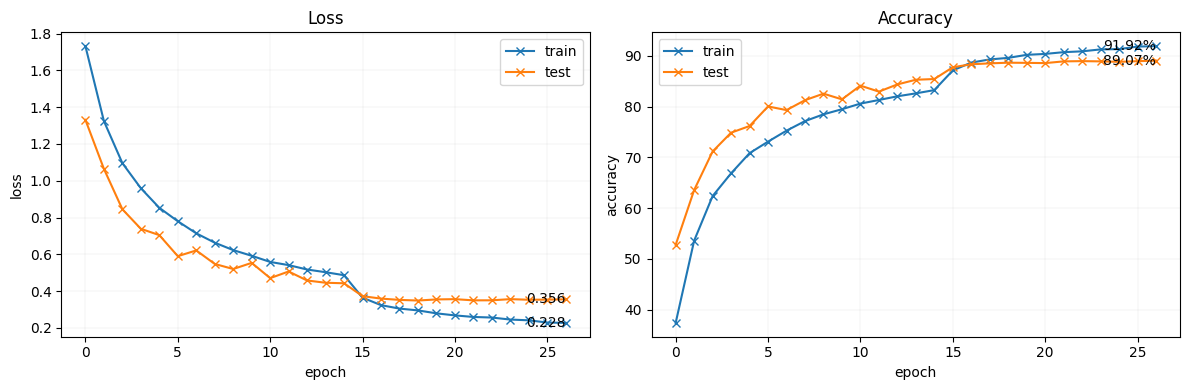

Epoch 26 Epoch Time: 11.57 sec.
Train Loss: 0.228 Train Accuracy: 91.92%
Test Loss: 0.356 Test Accuracy: 89.07%
Total train time: 318.51 sec.
Average epoch time: 3.19 sec.


In [14]:
results = train_and_evaluate(
    m_AlexNet,
    trainloader,
    testloader,
    criterion,
    optimizer,
    scheduler,
    num_epochs,
)

In [15]:
torch.save(m_AlexNet.state_dict(), 'pw1_model.pth')

In [16]:
# model.load_state_dict(torch.load('pw1_model.pth'))
# model.eval()

### Results

In [17]:
results_df = pd.DataFrame(results)
results_df = results_df.drop([0, 2])  # drop train/test losses
results_df_max = results_df.max(axis=1)
results_df_max

1    91.918
3    89.070
dtype: float64

In [18]:
results_df_max.to_csv("pw1_results.csv", index=False)